In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from vecstack import stacking

D:\AnacondaNavigator\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [230]:
df = pd.read_csv(r'C:/Users/Venom/Desktop/694560_1215964_bundle_archive/preprocessed_data.csv')

In [231]:
df.shape

(2758800, 12)

In [232]:
df.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date'],
      dtype='object')

In [233]:
df.Date.max(),df.Date.min()

('2019-12-31', '1995-01-01')

In [234]:
df.shape

(2758800, 12)

In [235]:
df.dtypes

Region              object
Country             object
City                object
Month                int64
Day                  int64
Year                 int64
AvgTemperature     float64
Latitude           float64
Longitude          float64
dist_from_north    float64
dist_from_south    float64
Date                object
dtype: object

In [236]:
#yyyy-mm-dd

In [237]:
df['Date'] = pd.to_datetime(df['Date'])

In [238]:
df.Date.quantile(0),df.Date.quantile(1)

(Timestamp('1995-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [239]:
def train_test_split(data,column,train_start_date, train_end_date,test_start_date,test_end_date):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date =  pd.to_datetime(train_end_date)
    test_start_date =  pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)
    data[column] = pd.to_datetime(data[column])
    train = data.loc[(data[column]>=train_start_date)&(data[column]<=train_end_date)]
    test = data.loc[(data[column]>=test_start_date)&(data[column]<=test_end_date)]
    train.reset_index(drop =True,inplace = True)
    test.reset_index(drop =True,inplace = True)
    return train,test
def get_mape(actual, predicted):
    y_true, y_pred = np.array(actual), np.array(predicted)
    return np.round( np.mean(np.abs((actual - predicted)/ actual)) * 100, 2)

In [240]:
df['prev_day'] = df.groupby('City').AvgTemperature.shift(1)
df['prev_2day'] = df.groupby('City').AvgTemperature.shift(2)
df['prev_3day'] = df.groupby('City').AvgTemperature.shift(3)
df['prev_year'] = df.groupby('City').AvgTemperature.shift(365)
df['prev_2year'] = df.groupby('City').AvgTemperature.shift(365*2)
df['prev_3year'] = df.groupby('City').AvgTemperature.shift(365*3)

In [241]:
df['Season'] = (df.Month%12 + 3)//3

In [242]:
x_train,x_test = train_test_split(df[(df.Region!='North America')].copy(),'Date','1995-01-01','2018-12-30','2018-12-31','2019-12-31')

In [243]:
x_train.shape,x_test.shape

((1203084, 19), (46940, 19))

In [244]:
cat = [i for i in x_train.columns if x_train[i].dtypes=='object']

In [245]:
cat

['Region', 'Country', 'City']

In [246]:
region_temp_mapper = x_train.groupby('Region').AvgTemperature.mean().to_dict()
country_temp_mapper =  x_train.groupby('Country').AvgTemperature.mean().to_dict()
city_temp_mapper =  x_train.groupby('City').AvgTemperature.mean().to_dict()

In [247]:
x_train['Region_enc'] = x_train['Region'].map(region_temp_mapper)
x_test['Region_enc'] = x_test['Region'].map(region_temp_mapper)

x_train['Country_enc'] = x_train['Country'].map(country_temp_mapper)
x_test['Country_enc'] = x_test['Country'].map(country_temp_mapper)

x_train['City_enc'] = x_train['City'].map(city_temp_mapper)
x_test['City_enc'] = x_test['City'].map(city_temp_mapper)

In [248]:
x_train['is_neg_percent'] = np.where(x_train.AvgTemperature<0,1,0)
neg_mapper = x_train.groupby('City').apply(lambda x:x.is_neg_percent.mean()*100).to_dict()
x_train['is_neg_percent'] = x_train['City'].map(neg_mapper)
x_test['is_neg_percent'] = x_test['City'].map(neg_mapper)

In [249]:
x_train['combined'] = x_train.Country.astype(str)+"_"+x_train.Month.astype(str)
country_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['country_month_mean'] = x_train.combined.map(country_month_details)

x_test['combined'] = x_test.Country.astype(str)+"_"+x_test.Month.astype(str)
x_test['country_month_mean'] = x_test.combined.map(country_month_details)


In [250]:
x_train['combined'] = x_train.City.astype(str)+"_"+x_train.Season.astype(str)
city_season_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['city_season_mean'] = x_train.combined.map(city_season_details)

x_test['combined'] = x_test.City.astype(str)+"_"+x_test.Season.astype(str)
x_test['city_season_mean'] = x_test.combined.map(city_season_details)


In [251]:
x_train['combined'] = x_train.City.astype(str)+"_"+x_train.Month.astype(str)
city_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['city_month_mean'] = x_train.combined.map(city_month_details)

x_test['combined'] = x_test.City.astype(str)+"_"+x_test.Month.astype(str)
x_test['city_month_mean'] = x_test.combined.map(city_month_details)


In [252]:
x_train.drop('combined',inplace=True,axis = 1)
x_test.drop('combined',inplace=True,axis = 1)

In [253]:
x_train['days_rolling_mean'] = x_train.groupby('City')['AvgTemperature'].rolling(30).mean().reset_index(0,drop=True)
rolling_mean_mapper = x_train.groupby('City').days_rolling_mean.mean().to_dict()
x_test['days_rolling_mean'] = x_test['City'].map(rolling_mean_mapper)

In [254]:
x_train['years_rolling_mean'] = x_train.groupby('City')['AvgTemperature'].rolling(365).mean().reset_index(0,drop=True)
rolling_mean_mapper = x_train.groupby('City').days_rolling_mean.mean().to_dict()
x_test['years_rolling_mean'] = x_test['City'].map(rolling_mean_mapper)

In [255]:
y_train = x_train.AvgTemperature
y_test = x_test.AvgTemperature

In [256]:
x_train.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date',
       'prev_day', 'prev_2day', 'prev_3day', 'prev_year', 'prev_2year',
       'prev_3year', 'Season', 'Region_enc', 'Country_enc', 'City_enc',
       'is_neg_percent', 'country_month_mean', 'city_season_mean',
       'city_month_mean', 'days_rolling_mean', 'years_rolling_mean'],
      dtype='object')

In [257]:
selected = ['Month', 'Longitude', 'dist_from_north',
       'prev_day','prev_2day', 'prev_3day', 'prev_year','prev_2year','prev_3year','city_month_mean',
            'days_rolling_mean','years_rolling_mean','is_neg_percent','city_season_mean']
len(selected)

14

In [258]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1203084, 28), (46940, 28), (1203084,), (46940,))

In [259]:
x_train.Date.max()-x_train.Date.min(),x_test.Date.max()-x_test.Date.min()

(Timedelta('8764 days 00:00:00'), Timedelta('365 days 00:00:00'))

In [260]:
x_train.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date',
       'prev_day', 'prev_2day', 'prev_3day', 'prev_year', 'prev_2year',
       'prev_3year', 'Season', 'Region_enc', 'Country_enc', 'City_enc',
       'is_neg_percent', 'country_month_mean', 'city_season_mean',
       'city_month_mean', 'days_rolling_mean', 'years_rolling_mean'],
      dtype='object')

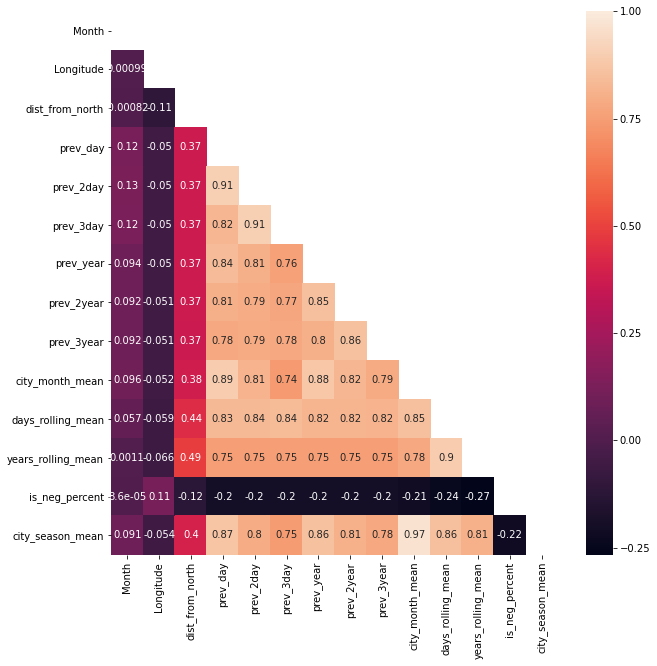

In [261]:
plt.figure(figsize=(10,10))
matrix = np.triu(x_train[selected].corr())
sns.heatmap(x_train[selected].corr(), annot=True, mask=matrix)

In [273]:
model = lgb.LGBMRegressor(n_estimators=500, max_depth=6,learning_rate=0.01)
x_train['weights'] = np.where(x_train.AvgTemperature<20,3,1)
model.fit(x_train[selected].fillna(0,axis = 1),y_train,x_train['weights'] )

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=6,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [275]:
x_train.weights.value_counts()

1    1188228
3      14856
Name: weights, dtype: int64

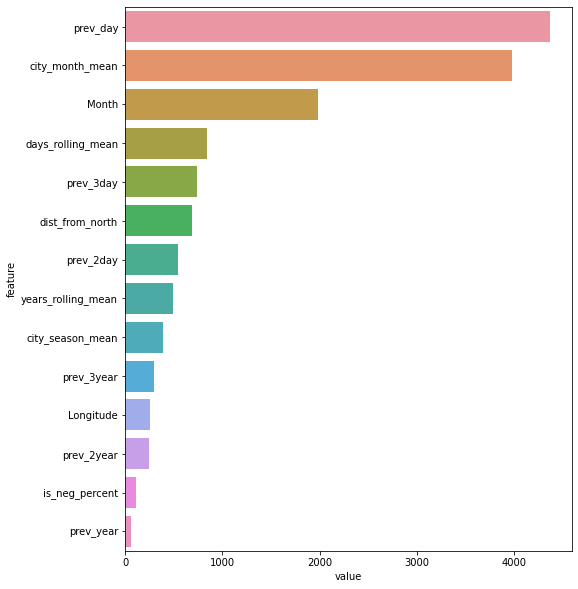

In [276]:
feat_importance = pd.DataFrame()
feat_importance["feature"] = selected
feat_importance["value"] = model.feature_importances_
feat_importance.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="value", data=feat_importance)

In [277]:
pred = model.predict(x_test[selected])

In [278]:
rmse = sqrt(mean_squared_error(y_test, pred))
print("RMSE : ",rmse)

RMSE :  4.169004134842068


In [279]:
print("MAE : ",mean_absolute_error(y_test, pred))

MAE :  2.9965075921423403


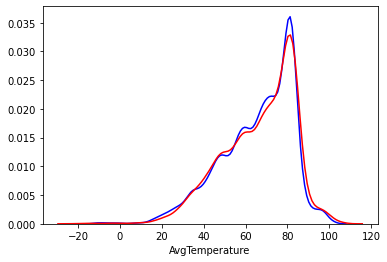

In [280]:
sns.distplot(pred, hist=False,color='b')
sns.distplot(y_test, hist=False,color='r')

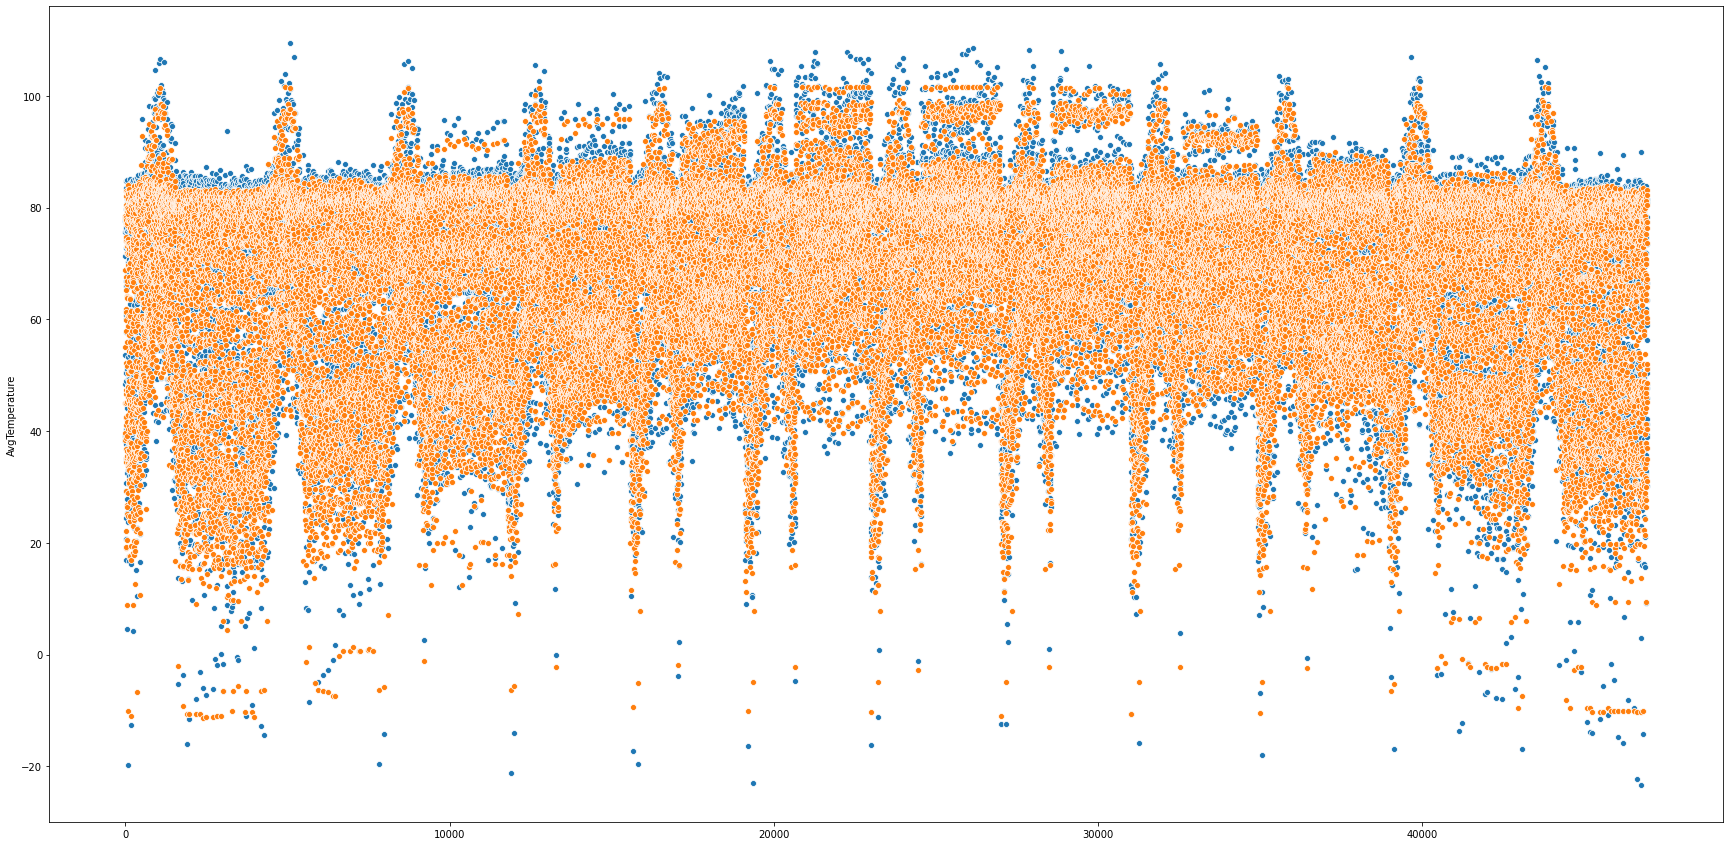

In [281]:
plt.figure(figsize=(30,15))
sns.scatterplot(np.arange(y_test.shape[0]),y_test)
sns.scatterplot(np.arange(y_test.shape[0]),pred)

In [282]:
result = pd.DataFrame()
result = x_test
result['actual'] = y_test
result['predicted'] = pred

In [283]:
result['error'] = np.abs(result.actual-result.predicted)

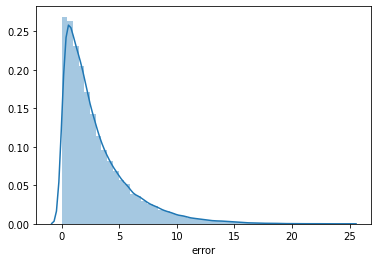

In [284]:
sns.distplot(result.error)

In [285]:
print("SPOT ON % : ",result[result.predicted.astype(int)==result.actual.astype(int)].shape[0]/result.shape[0]*100)
print("+-3 % : ",result[result.error<=3].shape[0]/result.shape[0]*100)
print("+-5 % : ",result[result.error<=5].shape[0]/result.shape[0]*100)
print("+-7 % : ",result[result.error<=7].shape[0]/result.shape[0]*100)
print("+-10 % : ",result[result.error<=10].shape[0]/result.shape[0]*100)

SPOT ON % :  13.323391563698339
+-3 % :  63.73242437153813
+-5 % :  81.42309331060929
+-7 % :  90.3898593949723
+-10 % :  96.55517682147422
